Load CSV Data to pandas dataframe and clean the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# open file
f = open("TEST.csv","r")
df = pd.read_csv(f, dtype = object)

# trim excess rows and convert non-numerics to NaNs
df = df.apply(pd.to_numeric, errors='coerce')
df.drop(columns = df.columns[17:], inplace = True)
df.dropna(axis = 'index', inplace = True) # drop any rows with any NaNs

# set type of each column
dtype = {'ti':np.int64,'e':np.int64,'st':np.int64,'pr':np.float64,
         'te':np.float64,'a':np.float64,'Vs':np.float64,'Vb':np.float64,
         'c':np.float64,'po':np.int64,'Sa':np.int64,'Ax':np.int64,
         'Ay':np.int64,'Az':np.int64,'Gx':np.int64,
         'Gy':np.int64,'Gz':np.int64}
df = df.astype(dtype)

# check for any reported errors (if none, drop the error column)
if (df.e.max() == 0):
    df.drop(columns = 'e', inplace = True)
else:
    print("Errors: ",df.e.unique())
    
# show beginning of df
df.head()

,ti,st,pr,te,a,Vs,Vb,c,po,Sa,Ax,Ay,Az,Gx,Gy,Gz
0,474,0,100698.71,23.27,135.93,0.13,0.89,1.1,0,93,-54,22,1261,19,8,-110
1,506,4,100698.71,23.27,135.93,0.09,0.89,1.2,0,0,-74,16,1264,28,2,-101
2,642,1,100699.28,23.30,135.89,0.11,0.89,0.9,0,0,-72,22,1268,24,4,-105
3,777,1,100701.99,23.33,135.66,0.10,0.89,1.1,0,0,-77,13,1248,24,5,-110
4,912,1,100700.53,23.34,135.78,0.11,0.88,1.4,0,0,-75,7,1268,22,12,-111


Histogram of times to illustrate that there are a bunch of small times

(-2495.75, 10167.377]         4279
(10167.377, 20177.755]        1337
(20177.755, 30188.132]        1112
(30188.132, 40198.509]         771
(40198.509, 50208.887]         639
                              ... 
(2242481.528, 2252491.906]      69
(2352595.679, 2362606.057]      69
(2422668.321, 2432678.698]      69
(2202440.019, 2212450.396]      69
(2392637.189, 2402647.566]      69
Name: ti, Length: 265, dtype: int64

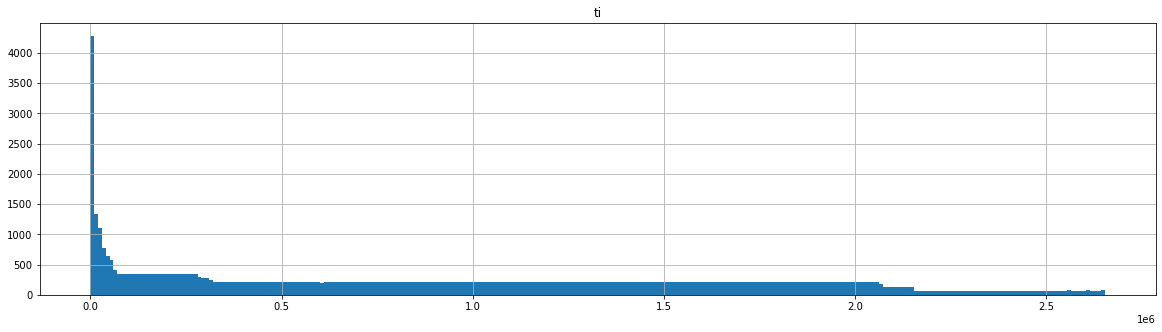

In [2]:
time_per_bin_ms = 10000
num_bins = int(df.ti.max()/time_per_bin_ms)
df.hist(column = 'ti', bins = num_bins, figsize = (20,5))
ti_count = pd.cut(df['ti'], bins = num_bins)
ti_count.value_counts()

Now we set about correcting the strange times. To do this, we will compute the mean delta time and round it to an int. First, we visuallize the data to determine which delta t's correspond to the average

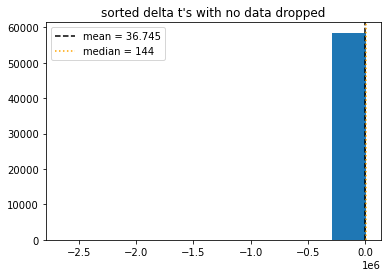

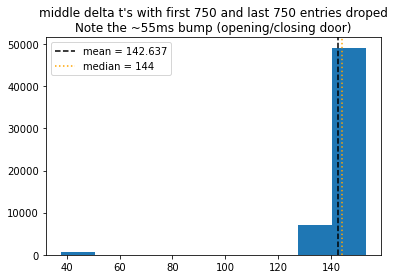

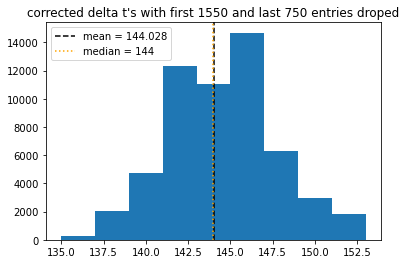

In [3]:
# most common delta-t for measurements, essentially avg timestep between measurements
# median is taken because of extreme values when arduino resets from large time
del_ts = df[['ti']].diff(periods = 1, axis = 'index')
hd_offset = 750 # offset from head and tail of data
h_offset = 1550 # offset from head of data
t_offset = 750 # offset from tail of data
sorted_dts = (del_ts['ti'])[1:].sort_values()
middle_dts = sorted_dts[hd_offset-1:sorted_dts.size-hd_offset-1]
corrected_dts = sorted_dts[h_offset-1:sorted_dts.size-t_offset-1]

plt.figure()
plt.title('sorted delta t\'s with no data dropped')
plt.hist(sorted_dts, bins = 9)
plt.axvline(x = sorted_dts.mean(), ls = '--', c = 'k', label = f'mean = {round(sorted_dts.mean(),3)}')
plt.axvline(x = sorted_dts.median(), ls = ':', c = 'orange', label = f'median = {round(sorted_dts.median())}')
plt.legend()

plt.figure()
plt.title(f'middle delta t\'s with first {hd_offset} and last {hd_offset} entries droped\nNote the ~55ms bump (opening/closing door)')
plt.hist(middle_dts, bins = 9)
plt.axvline(x = middle_dts.mean(), ls = '--', c = 'k', label = f'mean = {round(middle_dts.mean(),3)}')
plt.axvline(x = middle_dts.median(), ls = ':', c = 'orange', label = f'median = {round(middle_dts.median())}')
plt.legend()
print("")

plt.figure()
plt.title(f'corrected delta t\'s with first {h_offset} and last {t_offset} entries droped')
plt.hist(corrected_dts, bins = 9)
plt.axvline(x = corrected_dts.mean(), ls = '--', c = 'k', label = f'mean = {round(corrected_dts.mean(),3)}')
plt.axvline(x = corrected_dts.median(), ls = ':', c = 'orange', label = f'median = {round(corrected_dts.median())}')
plt.legend()

mdt = round(corrected_dts.mean())

Now that we have a reasonable mean delta t for regular memory writes, we will look at the trends over time while the door is open.

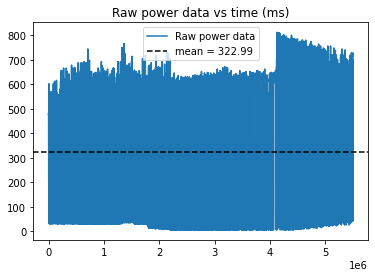

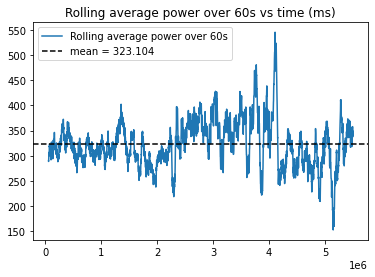

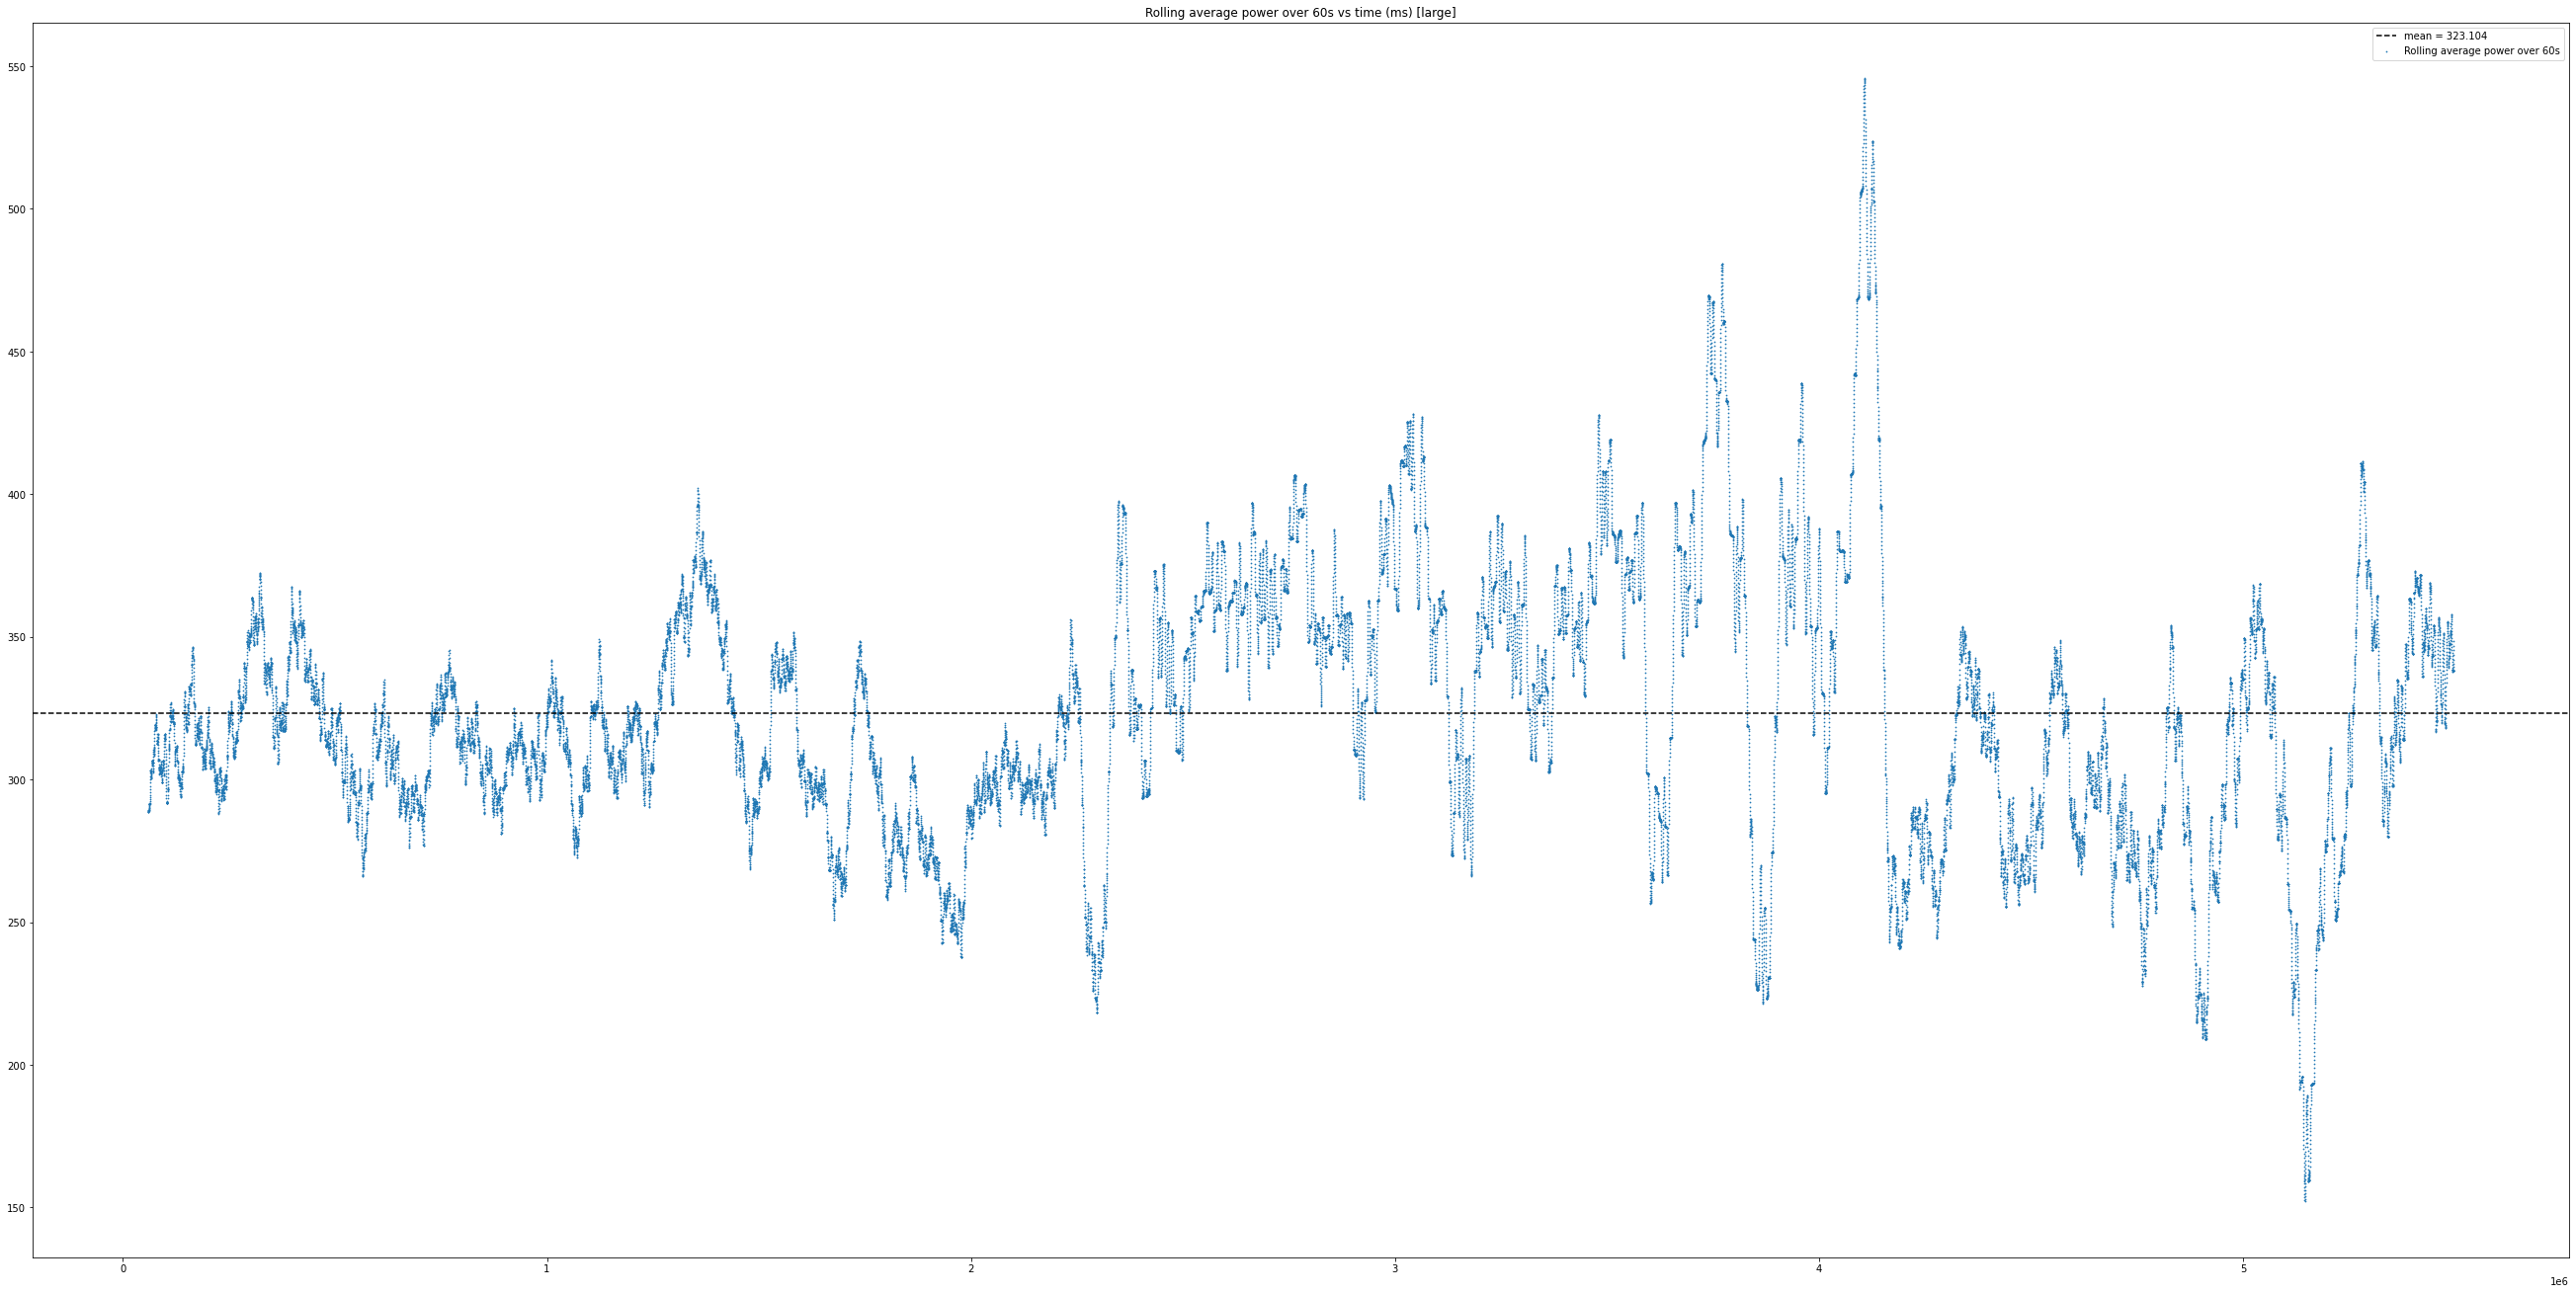

In [4]:
# get only rows where the door is open
open_st = 3
open_df = df.loc[df['st'] == open_st]

# disable a warning quickly because it won't make any problems (probably)
pd.options.mode.chained_assignment = None
open_df['ti_c'] = np.arange(0,len(open_df)*mdt,mdt)
pd.options.mode.chained_assignment = 'warn' # default = 'warn'

plt.figure()
plt.title('Raw power data vs time (ms)')
x = open_df.ti_c
y = open_df.po
plt.plot(x, y, label = 'Raw power data')
plt.axhline(y = y.mean(), ls = '--', c = 'k', label = f'mean = {round(y.mean(),3)}')
plt.legend()

window_length_s = 60
plt.figure()
plt.title(f'Rolling average power over {window_length_s}s vs time (ms)')
x = open_df.ti_c
y = open_df.po.rolling(window=round(window_length_s*1000/mdt)).mean()
plt.plot(x, y, label = f'Rolling average power over {window_length_s}s')
plt.axhline(y = y.mean(), ls = '--', c = 'k', label = f'mean = {round(y.mean(),3)}')
plt.legend()

# larger plot with same settings as above
plt.figure(figsize = (46,23))
plt.title(f'Rolling average power over {window_length_s}s vs time (ms) [large]')
plt.scatter(x, y, s = 3, linewidth = 0, label = f'Rolling average power over {window_length_s}s')
plt.axhline(y = y.mean(), ls = '--', c = 'k', label = f'mean = {round(y.mean(),3)}')
plt.legend()

Now we use the mean power, mean delta t, number of timesteps to estimate total energy produced during the open stage

Energy produced during open stage ~= 0.493Wh
Energy produced during all other stages ~= 0.048Wh
Total energy produced during all stages ~= 0.541Wh


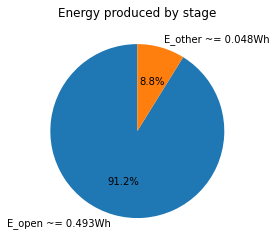

In [5]:
open_mean_po_W = open_df.po.mean()/1000
open_num_ts = len(open_df)
open_time_s = open_num_ts*mdt/1000
open_energy_Wh = open_mean_po_W*open_time_s/3600

total_mean_po_W = df.po.mean()/1000
total_num_ts = len(df)
total_time_s = total_num_ts*mdt/1000
total_energy_Wh = total_mean_po_W*total_time_s/3600

other_energy_Wh = total_energy_Wh-open_energy_Wh

print(f'Energy produced during open stage ~= {round(open_energy_Wh,3)}Wh')
print(f'Energy produced during all other stages ~= {round(other_energy_Wh,3)}Wh')
print(f'Total energy produced during all stages ~= {round(total_energy_Wh,3)}Wh')

labels = f'E_open ~= {round(open_energy_Wh,3)}Wh', f'E_other ~= {round(other_energy_Wh,3)}Wh'
sizes = [open_energy_Wh/total_energy_Wh, other_energy_Wh/total_energy_Wh]

plt.figure()
plt.title("Energy produced by stage")
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.show()

Make plot of power and altitude over time to visualize the mission.

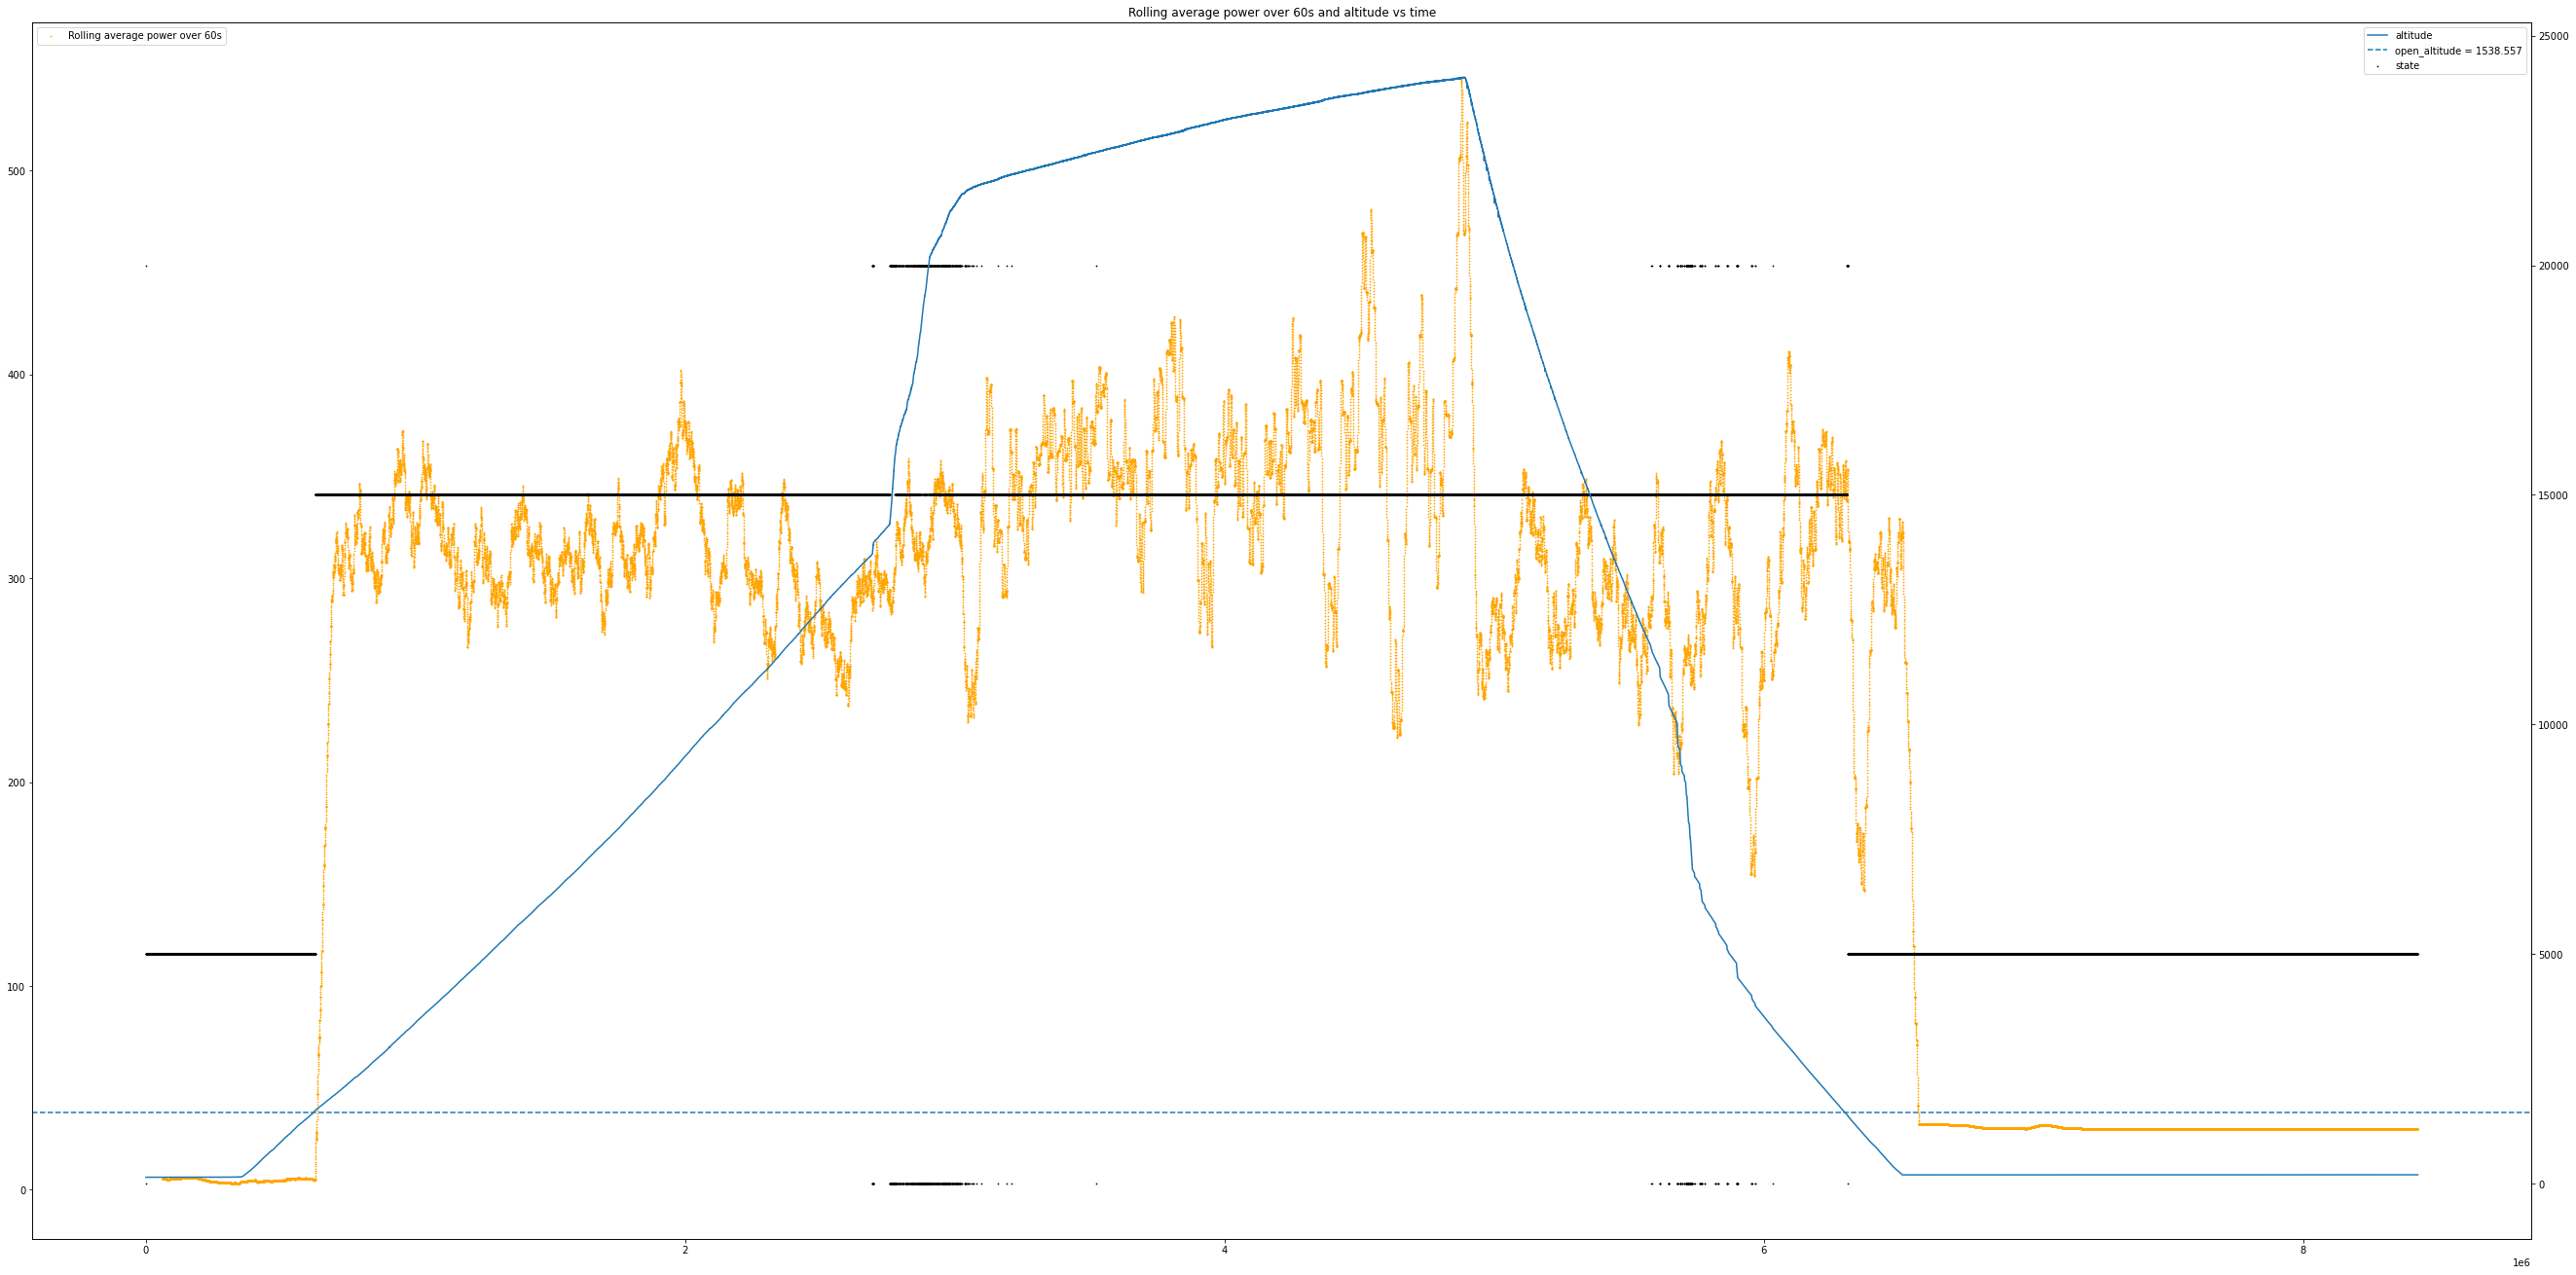

In [11]:
pd.options.mode.chained_assignment = None
df['ti_c'] = np.arange(0,len(df)*mdt,mdt)
pd.options.mode.chained_assignment = 'warn' # default = 'warn'


# Power and altitude vs time
window_length_s = 60
x = df.ti_c
y = df.po.rolling(window=round(window_length_s*1000/mdt)).mean()
fig, ax = plt.subplots(figsize = (46,23))
plt.title(f'Rolling average power over {window_length_s}s and altitude vs time')
ax.scatter(x, y, s = 3, c = 'orange', linewidth = 0, label = f'Rolling average power over {window_length_s}s')
ax.legend(loc = 'upper left')

# values from open pressure, local pressure, and BMP_280 source code to get exact open altitude used to trigger payload
LOCAL_P_MBAR = 1023.37
OPEN_PRESSURE = 85000
open_altitude = 44330*(1.0-(OPEN_PRESSURE/100/LOCAL_P_MBAR)**0.1903)

ax2 = ax.twinx()
ax2.plot(x, df.a, label = f'altitude')
ax2.axhline(y = open_altitude, ls = '--', label = f'open_altitude = {round(open_altitude,3)}')

ax2.scatter(x, df.st*5000, s = 3, c = 'k', alpha = 1, linewidth = 0, label = f'state')
ax2.legend(loc = 'upper right')